In [2]:
import pandas as pd
!pip install river

In [3]:
dataset = pd.read_csv("finance.csv")

In [4]:
dataset.head()

,time,value
0,2022-07-22 10:28:35,0.025808
1,2022-07-22 10:33:35,0.616177
2,2022-07-22 10:38:36,0.616177
3,2022-07-22 10:43:37,1.100507
4,2022-07-22 10:48:36,-0.044577


In [5]:
params = {'converters': {'value': float},'parse_dates': {'time': "%Y-%m-%d %H:%M:%S"}}




dataset = dict()
from river import stream
for x, y in stream.iter_csv('finance.csv', target = 'value', **params):
    print(x,y)

{'time': datetime.datetime(2022, 7, 22, 10, 28, 35)} 0.025808099608183845
{'time': datetime.datetime(2022, 7, 22, 10, 33, 35)} 0.6161768921730953
{'time': datetime.datetime(2022, 7, 22, 10, 38, 36)} 0.6161768921730953
{'time': datetime.datetime(2022, 7, 22, 10, 43, 37)} 1.1005073910122758
{'time': datetime.datetime(2022, 7, 22, 10, 48, 36)} -0.0445770393033232
{'time': datetime.datetime(2022, 7, 22, 10, 53, 35)} -0.0445770393033232
{'time': datetime.datetime(2022, 7, 22, 10, 58, 35)} 0.6991721637759272
{'time': datetime.datetime(2022, 7, 22, 11, 3, 35)} 0.6161768921730953
{'time': datetime.datetime(2022, 7, 22, 11, 8, 35)} 0.6161768921730953
{'time': datetime.datetime(2022, 7, 22, 11, 18, 37)} 1.4841174003594793
{'time': datetime.datetime(2022, 7, 22, 11, 23, 35)} 1.4841174003594793
{'time': datetime.datetime(2022, 7, 22, 11, 28, 36)} 0.9153650878428139
{'time': datetime.datetime(2022, 7, 22, 11, 33, 34)} 1.4201790692709686
{'time': datetime.datetime(2022, 7, 22, 11, 43, 37)} 1.4201790

In [94]:
from river import compose
from river import linear_model
from river import metrics
from river import evaluate
from river import preprocessing
from river import feature_extraction
from river import stats
from river import optim
from river import facto
from river import model_selection
from river import time_series

In [124]:
import math
import datetime
import numpy as np

hour_list = [str(i) for i in range (0,24)]
minute_list = [f'{str(i)} min' for i in range (0, 60)]
def get_hour(x):
    x['h'] = x['time'].hour
    return x
print(get_hour({'time': datetime.datetime(2022, 7, 22, 15, 3, 37)}))

def get_minute(x):
    x['m'] = x['time'].minute//20 + 1
    return x

def get_day(x):
    
    return {'d' : x['time'].day}

def get_hour_sin_and_cos(x):
    x['sin_h'] = np.sin(np.pi*(x['time'].hour)/12)
    x['cos_h'] = np.cos(np.pi*(x['time'].hour)/12)
    return {'sin_h' : np.sin(np.pi*(x['time'].hour)/12), 'cos_h': np.cos(np.pi*(x['time'].hour)/12)}
print(get_hour_sin_and_cos({'time': datetime.datetime(2022, 7, 22, 6, 3, 37)}))

def get_minute_distances(x):
    x['sin_m'] = np.sin(np.pi*(x['time'].minute)/30)
    x['cos_m'] = np.cos(np.pi*(x['time'].minute)/30)
    return {'sin_m' : np.sin(np.pi*(x['time'].minute)/30), 'cos_m': np.cos(np.pi*(x['time'].minute)/30)}

def get_date_progress(x):
    return {'date': x['time'].toordinal() - datetime.datetime(2022, 1, 1, 0, 0).toordinal()}

{'time': datetime.datetime(2022, 7, 22, 15, 3, 37), 'h': 15}
{'sin_h': 1.0, 'cos_h': 6.123233995736766e-17}


In [129]:
models = [linear_model.LinearRegression(optimizer=optim.SGD(lr=lr)) for lr in [0.01, 0.02, 0.005, 0.0001]]

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
#         ('day', compose.FuncTransformer(get_day)),
        ('date_progress', compose.FuncTransformer(get_date_progress)),
        ('cyclic_hour', compose.FuncTransformer(get_hour_sin_and_cos))
#         ('minute', compose.FuncTransformer(get_minute_distances))
    )))
model += (
    get_hour | 
        feature_extraction.TargetAgg(
            by=['h'], how=stats.Mean()
        
    
))
model += (
    get_minute | 
        feature_extraction.TargetAgg(
            by=['m'], how=stats.Mean()
        
    
))
# model += (
#     get_day | 
#         feature_extraction.TargetAgg(
#             by=['d'], how=stats.Mean()
        
    
# ))
model |=  preprocessing.StandardScaler()
model |=  model_selection.EpsilonGreedyRegressor(models, epsilon=0.025, decay=0.1, burn_in=100, seed=1)

metric = metrics.MAE() + metrics.R2()
# model = preprocessing.TargetStandardScaler(regressor=model)
evaluate.progressive_val_score(stream.iter_csv('finance.csv', target = 'value', **params), model, metric, print_every=50)

[50] MAE: 0.840889, R2: 0.278742
[100] MAE: 0.649016, R2: 0.405836
[150] MAE: 0.600423, R2: 0.465124
[200] MAE: 0.522928, R2: 0.506325
[250] MAE: 0.491717, R2: 0.48276
[300] MAE: 0.598819, R2: 0.355819
[350] MAE: 0.626821, R2: 0.291776
[400] MAE: 0.635314, R2: 0.272244
[450] MAE: 0.604362, R2: 0.28798
[500] MAE: 0.550118, R2: 0.307064
[550] MAE: 0.506268, R2: 0.317429
[600] MAE: 0.467605, R2: 0.31756
[650] MAE: 0.433899, R2: 0.317581
[700] MAE: 0.404904, R2: 0.317943
[750] MAE: 0.3796, R2: 0.320741
[800] MAE: 0.362609, R2: 0.331193
[850] MAE: 0.355372, R2: 0.337403
[900] MAE: 0.347783, R2: 0.334139
[950] MAE: 0.336942, R2: 0.332634
[1,000] MAE: 0.356285, R2: 0.304451


MAE: 0.356285, R2: 0.304451

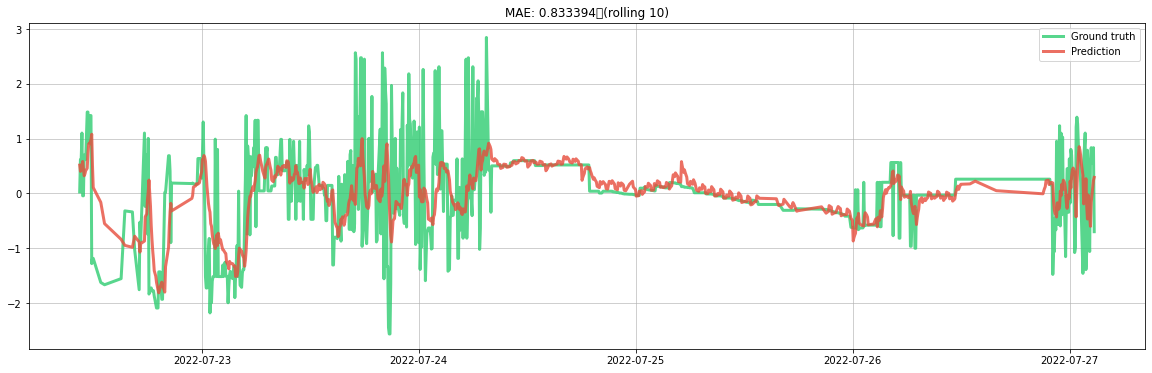

In [130]:
from river import metrics
import matplotlib.pyplot as plt


def evaluate_model(model): 

    metric = metrics.Rolling(metrics.MAE(), 10)

    dates = []
    y_trues = []
    y_preds = []

    for x, y in stream.iter_csv('finance.csv', target = 'value', **params):

        # Obtain the prior prediction and update the model in one go
        y_pred = model.predict_one(x)
        model.learn_one(x, y)

        # Update the error metric
        metric.update(y, y_pred)

        # Store the true value and the prediction
        dates.append(x['time'])
        y_trues.append(y)
        y_preds.append(y_pred)

    # Plot the results
    fig, ax = plt.subplots(figsize=(20, 6))
    ax.grid(alpha=0.75)
    ax.plot(dates, y_trues, lw=3, color='#2ecc71', alpha=0.8, label='Ground truth')
    ax.plot(dates, y_preds, lw=3, color='#e74c3c', alpha=0.8, label='Prediction')
    ax.legend()
    ax.set_title(metric)
evaluate_model(model)